# 1 - Import des bibliothèques

In [35]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
chemin_scripts = os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts'))
sys.path.append(chemin_scripts)

from fonctions_conso import importation, clean, traitement_valeurs_manquantes

# 2 - Récupération des données

In [20]:
url = "https://odre.opendatasoft.com/api/explore/v2.1/catalog/datasets/eco2mix-metropoles-tr/exports/csv?lang=fr&refine=libelle_metropole%3A%22M%C3%A9tropole%20du%20Grand%20Paris%22&facet=facet(name%3D%22libelle_metropole%22%2C%20disjunctive%3Dtrue)&timezone=Europe%2FParis&use_labels=true&delimiter=%3B"
df = traitement_valeurs_manquantes(clean(importation(url)))[['conso_final']]

In [21]:
df.head(2)

,conso_final
date_heure,
2020-01-01 01:00:00,5090.0
2020-01-01 01:15:00,5018.0


# 3 - Test de stationnarité

On va commencer par tester la stationnarité de la série des consommations d'électricité de la métropole parisienne afin de choisir par la suite le bon modèle de prédiction. Pour cela, on effectue le test de racine unitaire de Dickey-Füller augmenté (test ADF) dont les hypothèses sont les suivantes :

$$
\begin{cases}
H_0 : \text{présence de racine unitaire} \Leftrightarrow \text{série non stationnaire} \\
H_1 : \text{absence de racine unitaire} \Leftrightarrow \text{série stationnaire}
\end{cases}
$$

Les valeurs critiques du test ADF diffèrent selon l'hypothèse choisie pour le processus générateur de données (DGP) de la série temporelle :

- **DGP 1** (sans partie déterministe, option `regression='n'` dans adfuller) : 
$$ X_t = \phi X_{t-1} + \epsilon_t $$  
Valeur critique au seuil 5% pour le rejet de $H_0$ : -1,95

- **DGP 2** (avec constante, option `regression='c'` dans adfuller) :  
$$ X_t = a + \phi X_{t-1} + \epsilon_t $$  
Valeur critique au seuil 5% pour le rejet de $H_0$ : -2,89

- **DGP 3** (avec constante et trend, option `regression='ct'` dans adfuller) : 
$$ X_t = a + b t + \phi X_{t-1} + \epsilon_t $$  
Valeur critique au seuil 5% pour le rejet de $H_0$ : -3,45

Lorsque la valeur du test ADF est inférieure au seuil critique associé à l'hypothèse choisie, on rejette $H_0$, c’est-à-dire que la série est stationnaire.


In [36]:
def adf_table(series, alpha=0.05):
    results = []
    dgp = {'n' : 'DGP1', 'c' : 'DGP2', 'ct' : 'DGP3'}

    for reg, label in dgp.items():
        adf_result = adfuller(series, regression=reg)

        adf_stat = adf_result[0]
        crit_value = adf_result[4]['5%']

        conclusion = "Stationnaire" if adf_stat < crit_value else "Non stationnaire"

        results.append({
            "DGP": label,
            "ADF statistic": adf_stat,
            "Valeur critique (5%)": crit_value,
            "Conclusion": conclusion
        })

    return pd.DataFrame(results)

In [37]:
df_adf = adf_table(df)

In [38]:
df_adf

,DGP,ADF statistic,Valeur critique (5%),Conclusion
0,DGP1,-1.273610,-1.941001,Non stationnaire
1,DGP2,-5.760323,-2.861554,Stationnaire
2,DGP3,-5.762672,-3.410511,Stationnaire


**Conclusion** : la série est stationnaire autour d'une constante $\neq$ 0. On peut confirmer par ACF PACF puis prédire par ARIMA.

**ACF PACF**

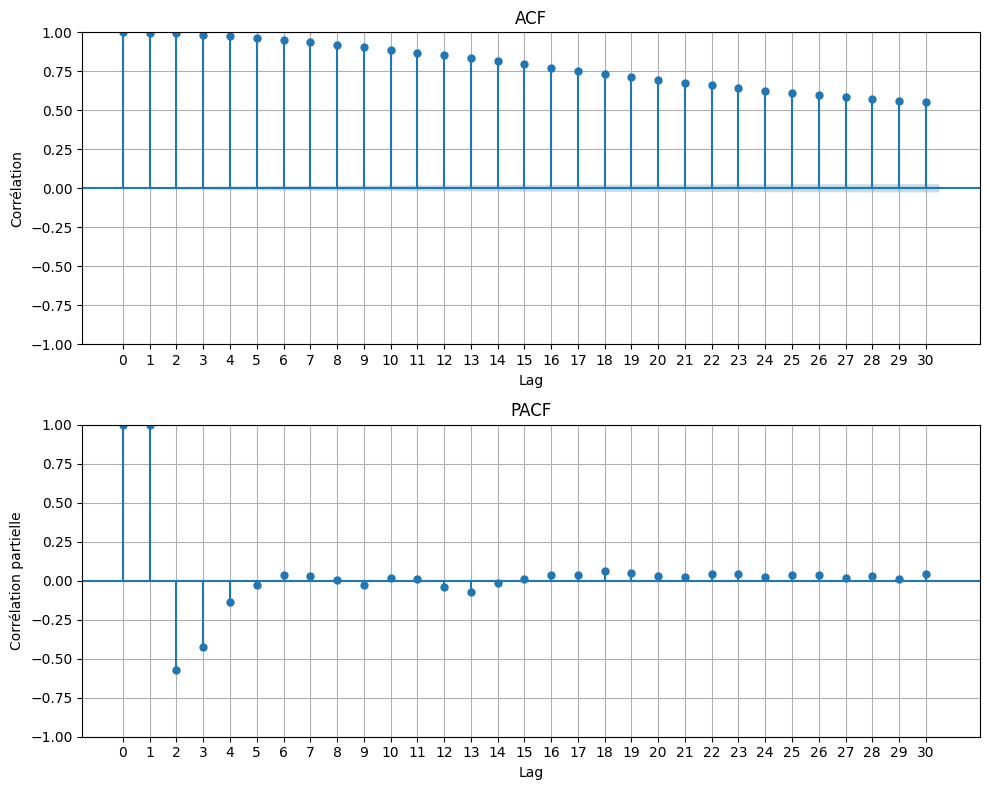

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Créer les subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Tracer l'ACF
plot_acf(df['conso_final'], lags=30, zero=True, ax=ax1)
ax1.set_title('ACF')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajuster les graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0, 31, 1))

# Tracer le PACF
plot_pacf(df['conso_final'], lags=30, zero=True, ax=ax2)
ax2.set_title('PACF')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation partielle')
ax2.grid(True)

# Ajuster les graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0, 31, 1))

# Ajuster les subplots
plt.tight_layout()

# Afficher le graphique
plt.show()